In [ ]:
# Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
!pwd

/content


In [ ]:
# import required modules
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import datetime
import matplotlib.pyplot as plt
from torchsummary import summary
import sklearn.metrics
import seaborn as sn
from collections import OrderedDict
# from saliency.attribution_methods import ConvOutput
# from saliency.ensembles import *
# from visualization import visualize_saliencys

In [ ]:
cd /content/drive/My Drive/PyTorch/data

/content/drive/My Drive/PyTorch/data


In [ ]:
# set random seed to get reproducible results
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
# Image processing
transform = transforms.Compose([ #torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                #torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                transforms.ToTensor(),
                                #transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])
                                ])
print(transform)

Compose(
    ToTensor()
)


In [ ]:
%%time
# take dataset from folders and split it into train, validation and test sets

# set paths
train_data_dir = 'cifar10/train/' # put path of training dataset
test_data_dir = 'cifar10/test/' # put path of test dataset

# Load Images

trainset = torchvision.datasets.ImageFolder(root= train_data_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.ImageFolder(root= test_data_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=4)

print('number of images in train set =',len(trainset))
print('trainset class-indices =',trainset.classes)
print('number of images in test set =',len(testset))
print('trainset class-indices =',testset.classes)

number of images in train set = 50000
trainset class-indices = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
number of images in test set = 10000
trainset class-indices = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
CPU times: user 291 ms, sys: 32.2 ms, total: 324 ms
Wall time: 2min 27s


In [ ]:
# Class names
classes = testset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# visualise a batch
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl: # here in single iteration images contains 128 images and labels contain 128 labels
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0)) # 16 columns
        break # we are breaking out with one iteration

CPU times: user 43.7 ms, sys: 36.3 ms, total: 80.1 ms
Wall time: 29 s


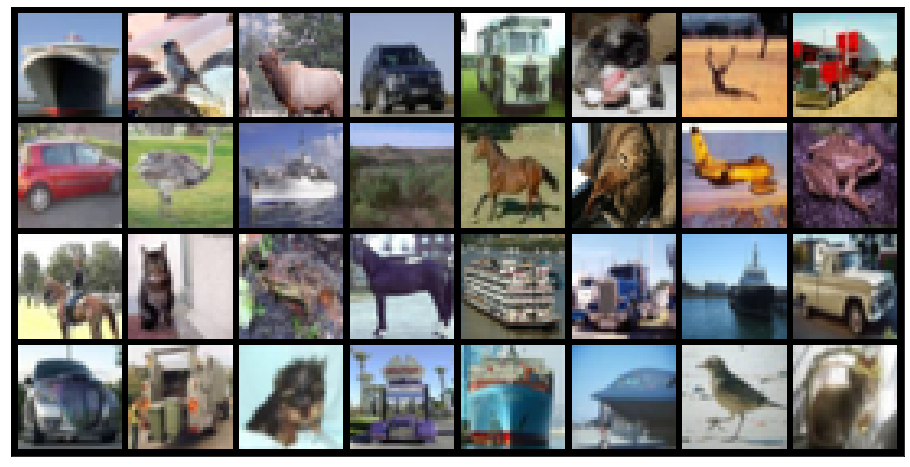

In [ ]:
%%time
# let's visualise a single trainset batch
show_batch(trainloader)

In [ ]:
# Helper class and functions to use GPU
# Code to use GPU if available
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Get the device name
device = get_default_device()
device

device(type='cuda')

In [ ]:
# load dataset to device
train_loader = DeviceDataLoader(trainloader, device)
test_loader = DeviceDataLoader(testloader, device)

In [ ]:
# Model Training Routines

In [ ]:
# Base Model
# Let's define the model by extending an ImageClassificationBase class which contains helper methods for training & validation.

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result,f):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        datetime_object = datetime.datetime.now()

        f.write(str(datetime_object)+" - "+"Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f} \n".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc'])) 

In [ ]:
# boiler plate code to fit the data
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, f, model_path, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    bench_mark = 0
    for epoch in range(epochs):
        # Training Phase
        train_losses = []
        train_accuracies=[]
        for i, data in enumerate(tqdm(train_loader), 0):
          model.train()
          loss, acc = model.training_step(data)
          train_losses.append(loss)
          train_accuracies.append(acc)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_acc'] = torch.stack(train_accuracies).mean().item()
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result, f)
        if bench_mark<result['val_acc']:
          torch.save(model.state_dict(), model_path)
          bench_mark = result['val_acc']
          print('model saved')
        history.append(result)
    return history

In [ ]:
# Let us look at how the network performs on the test dataset.
def test(testloader, model, set_name):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('\nAccuracy of the network on the %s images: %f %%' % (set_name, accuracy))
    print();print()
    return accuracy

In [ ]:
# class-wise accuracy
def classwise_test(testloader, model):
    n_class = len(classes) # number of classes
    predictions = np.array([])
    true_labels = np.array([])
    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data     
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions = np.append(predictions, predicted.detach().cpu().numpy())
            true_labels = np.append(true_labels, labels.detach().cpu().numpy())


    print('\nclass-wise accuracy')
    cm = sklearn.metrics.confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6,4))
    sn.heatmap(cm, annot=True, fmt="d") # font size
    plt.show()

    print("--------------------------------------------------------------------")
    print();print()

In [ ]:
def plot_train_graphs(history):
  train_acc = []
  val_acc = []
  train_loss = []
  val_loss = []
  for i in range(len(history)):
    train_acc.append(history[i]['train_acc'])
    val_acc.append(history[i]['val_acc'])
    train_loss.append(history[i]['train_loss'])
    val_loss.append(history[i]['val_loss'])

  fig,(ax1,ax2) =  plt.subplots(1,2,figsize=(15,5))

  ax1.plot(train_acc, label='accuracy')
  ax1.plot(val_acc, label = 'val_accuracy')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.legend(loc='lower right')

  ax2.plot(train_loss, label='loss')
  ax2.plot(val_loss, label = 'val_loss')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('loss')
  ax2.legend(loc='lower right')

  plt.show()

In [ ]:
# class Net(ImageClassificationBase):   
#     def __init__(self):
#         super(Net, self).__init__()

#         self.cnn_layers = nn.Sequential(
#             # Defining a 2D convolution layer
#             nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(4),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             # Defining another 2D convolution layer
#             nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(4),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )

#         self.linear_layers = nn.Sequential(
#             nn.Linear(4 * 8 * 8, 10)
#         )

#     # Defining the forward pass    
#     def forward(self, x):
#         x = self.cnn_layers(x)
#         x = x.view(x.size(0), -1)
#         x = self.linear_layers(x)
#         return x

In [ ]:
# # print model Summary
# model1 = Net()
# to_device(model1, device)
# summary(model1, (3,32,32))

In [ ]:
# # train model
# f = open("dummycnn.txt", "w")
# num_epochs = 2
# history1 = fit(num_epochs, model1, train_loader, test_loader, f=f, model_path='dummycnn.pth')
# f.close()

In [ ]:
# # Validating our model
# test(testloader, model1.cpu(), 'test')
# classwise_test(testloader, model1.cpu())

In [ ]:
# attention stuff

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio, pool_types):
        super(ChannelAttention, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels//reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels//reduction_ratio, in_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None 
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool.view(avg_pool.size(0), -1))
            elif pool_type=='max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool.view(max_pool.size(0), -1))

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        channel_att = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)

        return x * channel_att


class SpatialAttention(nn.Module):
    def __init__(self, k_size):
        super(SpatialAttention, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=k_size, padding=(k_size - 1)//2),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
    
    def forward(self, x):
        conv_concat = torch.cat((x.max(1)[0].unsqueeze(1), x.mean(1).unsqueeze(1)), dim=1)
        spatial_att_raw = self.conv_block(conv_concat)
        spatial_att = torch.sigmoid(spatial_att_raw).expand_as(x)
        return x * spatial_att


class CBAM(nn.Module):
    def __init__(self, in_channels, pool_types=['avg','max'], k_size=7, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.CA = ChannelAttention(in_channels, reduction_ratio, pool_types)
        self.SA = SpatialAttention(k_size)
        
    def forward(self, x):
        channel_att = self.CA(x)
        spatial_att = self.SA(channel_att)

        return spatial_att

In [ ]:
class SimpleCNN(ImageClassificationBase):
    def __init__(self, attention=None):
        super(SimpleCNN, self).__init__()
        # attention method
        self.attention = attention 
        # nb_channel and FCN size
        in_channels = 3
        fcn_size = 128*4*4
        
        self.feature_maps = OrderedDict()
        self.pool_locs = OrderedDict()

        self.features = nn.Sequential(
            # layer1
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),

            # layer2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),
 
            # layer3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=fcn_size, out_features=1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
            nn.Softmax(dim=1)
        )

        # Attention Modules
        if attention=='CBAM':
            ch_lst = [32,64,128]
            for i in range(3):
                self.__setattr__('cbam%d' % i, CBAM(ch_lst[i]))

        print('Model Complete')

    
    def forward(self, x):
        nb_layer = 0
        for _, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, _ = layer(x)
            elif isinstance(layer, nn.BatchNorm2d) and (self.attention=='CBAM'): # CBAM
                x = self.__getattr__('cbam%d' % nb_layer)(x)
                x = layer(x)
                nb_layer += 1
            else:
                x = layer(x)

        x = x.view(x.size(0), -1)
        output = self.classifier(x)

        return output

In [ ]:
# print model Summary
# simple cnn model without CBAM
model1 = SimpleCNN()
to_device(model1, device)
summary(model1, (3,32,32))

Model Complete
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4  [[-1, 32, 16, 16], [-1, 32, 16, 16]]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8  [[-1, 64, 8, 8], [-1, 64, 8, 8]]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12  [[-1, 128, 4, 4], [-1, 128, 4, 4]]               0
           Linear-13                 [-1, 1024]       2,098,1

In [ ]:
# train model
f = open("simplecnn.txt", "w")
num_epochs = 80
history1 = fit(num_epochs, model1, train_loader, test_loader, f=f, model_path='simplecnn.pth')
f.close()


Epoch [0], train_loss: 2.1302, train_acc: 0.3543, val_loss: 2.0078, val_acc: 0.4760
model saved



Epoch [1], train_loss: 1.9711, train_acc: 0.5085, val_loss: 1.9442, val_acc: 0.5338
model saved



Epoch [2], train_loss: 1.9079, train_acc: 0.5679, val_loss: 1.9338, val_acc: 0.5321



Epoch [3], train_loss: 1.8700, train_acc: 0.6047, val_loss: 1.8754, val_acc: 0.5964
model saved



Epoch [4], train_loss: 1.8380, train_acc: 0.6377, val_loss: 1.8602, val_acc: 0.6088
model saved



Epoch [5], train_loss: 1.8155, train_acc: 0.6573, val_loss: 1.8210, val_acc: 0.6467
model saved



Epoch [6], train_loss: 1.8000, train_acc: 0.6730, val_loss: 1.8270, val_acc: 0.6391



Epoch [7], train_loss: 1.7848, train_acc: 0.6875, val_loss: 1.8166, val_acc: 0.6492
model saved



Epoch [8], train_loss: 1.7715, train_acc: 0.7016, val_loss: 1.8180, val_acc: 0.6491



Epoch [9], train_loss: 1.7604, train_acc: 0.7124, val_loss: 1.8003, val_acc: 0.6691
model saved



Epoch [10], train_loss: 1.7333, train_acc: 0.7447, val_loss: 1.7847, val_acc: 0.6855
model saved



Epoch [11], train_loss: 1.7180, train_acc: 0.7591, val_loss: 1.7627, val_acc: 0.7091
model saved



Epoch [12], train_loss: 1.7042, train_acc: 0.7719, val_loss: 1.7526, val_acc: 0.7170
model saved



Epoch [13], train_loss: 1.6917, train_acc: 0.7853, val_loss: 1.7582, val_acc: 0.7135



Epoch [14], train_loss: 1.6822, train_acc: 0.7946, val_loss: 1.7294, val_acc: 0.7424
model saved



Epoch [15], train_loss: 1.6722, train_acc: 0.8040, val_loss: 1.7540, val_acc: 0.7164



Epoch [16], train_loss: 1.6640, train_acc: 0.8121, val_loss: 1.7780, val_acc: 0.6899



Epoch [17], train_loss: 1.6552, train_acc: 0.8209, val_loss: 1.7353, val_acc: 0.7336



Epoch [18], train_loss: 1.6478, train_acc: 0.8284, val_loss: 1.7231, val_acc: 0.7455
model saved



Epoch [19], train_loss: 1.6407, train_acc: 0.8360, val_loss: 1.7212, val_acc: 0.7467
model saved



Epoch [20], train_loss: 1.6325, train_acc: 0.8444, val_loss: 1.7208, val_acc: 0.7446



Epoch [21], train_loss: 1.6260, train_acc: 0.8511, val_loss: 1.7178, val_acc: 0.7493
model saved



Epoch [22], train_loss: 1.6205, train_acc: 0.8565, val_loss: 1.7067, val_acc: 0.7603
model saved



Epoch [23], train_loss: 1.6129, train_acc: 0.8645, val_loss: 1.7192, val_acc: 0.7475



Epoch [24], train_loss: 1.6081, train_acc: 0.8680, val_loss: 1.7219, val_acc: 0.7451



Epoch [25], train_loss: 1.6027, train_acc: 0.8739, val_loss: 1.7089, val_acc: 0.7579



Epoch [26], train_loss: 1.5968, train_acc: 0.8798, val_loss: 1.7143, val_acc: 0.7526



Epoch [27], train_loss: 1.5922, train_acc: 0.8848, val_loss: 1.7217, val_acc: 0.7447



Epoch [28], train_loss: 1.5866, train_acc: 0.8905, val_loss: 1.7116, val_acc: 0.7562



Epoch [29], train_loss: 1.5832, train_acc: 0.8934, val_loss: 1.7045, val_acc: 0.7620
model saved



Epoch [30], train_loss: 1.5792, train_acc: 0.8976, val_loss: 1.7040, val_acc: 0.7641
model saved



Epoch [31], train_loss: 1.5759, train_acc: 0.9010, val_loss: 1.7079, val_acc: 0.7606



Epoch [32], train_loss: 1.5706, train_acc: 0.9060, val_loss: 1.7140, val_acc: 0.7543



Epoch [33], train_loss: 1.5677, train_acc: 0.9079, val_loss: 1.6979, val_acc: 0.7670
model saved



Epoch [34], train_loss: 1.5628, train_acc: 0.9125, val_loss: 1.7068, val_acc: 0.7621



Epoch [35], train_loss: 1.5610, train_acc: 0.9150, val_loss: 1.7050, val_acc: 0.7616



Epoch [36], train_loss: 1.5571, train_acc: 0.9181, val_loss: 1.7057, val_acc: 0.7617



Epoch [37], train_loss: 1.5533, train_acc: 0.9220, val_loss: 1.7124, val_acc: 0.7534



Epoch [38], train_loss: 1.5514, train_acc: 0.9244, val_loss: 1.7042, val_acc: 0.7602



Epoch [39], train_loss: 1.5491, train_acc: 0.9258, val_loss: 1.7058, val_acc: 0.7616



Epoch [40], train_loss: 1.5447, train_acc: 0.9298, val_loss: 1.7059, val_acc: 0.7634



Epoch [41], train_loss: 1.5426, train_acc: 0.9317, val_loss: 1.6994, val_acc: 0.7677
model saved



Epoch [42], train_loss: 1.5407, train_acc: 0.9337, val_loss: 1.7055, val_acc: 0.7618



Epoch [43], train_loss: 1.5387, train_acc: 0.9351, val_loss: 1.6974, val_acc: 0.7710
model saved



Epoch [44], train_loss: 1.5363, train_acc: 0.9370, val_loss: 1.7037, val_acc: 0.7624



Epoch [45], train_loss: 1.5359, train_acc: 0.9379, val_loss: 1.7023, val_acc: 0.7619



Epoch [46], train_loss: 1.5323, train_acc: 0.9409, val_loss: 1.7183, val_acc: 0.7495



Epoch [47], train_loss: 1.5310, train_acc: 0.9418, val_loss: 1.7060, val_acc: 0.7596



Epoch [48], train_loss: 1.5299, train_acc: 0.9433, val_loss: 1.6995, val_acc: 0.7677



Epoch [49], train_loss: 1.5281, train_acc: 0.9447, val_loss: 1.6965, val_acc: 0.7711
model saved



Epoch [50], train_loss: 1.5260, train_acc: 0.9464, val_loss: 1.7056, val_acc: 0.7605



Epoch [51], train_loss: 1.5235, train_acc: 0.9478, val_loss: 1.6997, val_acc: 0.7661



Epoch [52], train_loss: 1.5220, train_acc: 0.9491, val_loss: 1.7115, val_acc: 0.7522



Epoch [53], train_loss: 1.5219, train_acc: 0.9496, val_loss: 1.7035, val_acc: 0.7636



Epoch [54], train_loss: 1.5212, train_acc: 0.9503, val_loss: 1.6982, val_acc: 0.7690



Epoch [55], train_loss: 1.5190, train_acc: 0.9518, val_loss: 1.6972, val_acc: 0.7699



Epoch [56], train_loss: 1.5193, train_acc: 0.9518, val_loss: 1.6973, val_acc: 0.7699



Epoch [57], train_loss: 1.5177, train_acc: 0.9530, val_loss: 1.7129, val_acc: 0.7551



Epoch [58], train_loss: 1.5173, train_acc: 0.9538, val_loss: 1.6999, val_acc: 0.7674



Epoch [59], train_loss: 1.5164, train_acc: 0.9539, val_loss: 1.7010, val_acc: 0.7662



Epoch [60], train_loss: 1.5161, train_acc: 0.9546, val_loss: 1.7002, val_acc: 0.7675



Epoch [61], train_loss: 1.5151, train_acc: 0.9548, val_loss: 1.6971, val_acc: 0.7683



Epoch [62], train_loss: 1.5141, train_acc: 0.9554, val_loss: 1.6967, val_acc: 0.7723
model saved



Epoch [63], train_loss: 1.5132, train_acc: 0.9564, val_loss: 1.6965, val_acc: 0.7705



Epoch [64], train_loss: 1.5117, train_acc: 0.9574, val_loss: 1.6994, val_acc: 0.7655



Epoch [65], train_loss: 1.5117, train_acc: 0.9575, val_loss: 1.6997, val_acc: 0.7670



Epoch [66], train_loss: 1.5103, train_acc: 0.9583, val_loss: 1.7018, val_acc: 0.7651



Epoch [67], train_loss: 1.5106, train_acc: 0.9580, val_loss: 1.6955, val_acc: 0.7716



Epoch [68], train_loss: 1.5098, train_acc: 0.9587, val_loss: 1.6961, val_acc: 0.7710



Epoch [69], train_loss: 1.5089, train_acc: 0.9594, val_loss: 1.7093, val_acc: 0.7573



Epoch [70], train_loss: 1.5099, train_acc: 0.9593, val_loss: 1.6994, val_acc: 0.7670



Epoch [71], train_loss: 1.5101, train_acc: 0.9593, val_loss: 1.6988, val_acc: 0.7693



Epoch [72], train_loss: 1.5093, train_acc: 0.9600, val_loss: 1.6996, val_acc: 0.7669



Epoch [73], train_loss: 1.5093, train_acc: 0.9601, val_loss: 1.7050, val_acc: 0.7602



Epoch [74], train_loss: 1.5088, train_acc: 0.9605, val_loss: 1.6944, val_acc: 0.7735
model saved



Epoch [75], train_loss: 1.5087, train_acc: 0.9608, val_loss: 1.7117, val_acc: 0.7561



Epoch [76], train_loss: 1.5086, train_acc: 0.9610, val_loss: 1.6992, val_acc: 0.7679



Epoch [77], train_loss: 1.5073, train_acc: 0.9617, val_loss: 1.7001, val_acc: 0.7672



Epoch [78], train_loss: 1.5069, train_acc: 0.9618, val_loss: 1.6994, val_acc: 0.7675



Epoch [79], train_loss: 1.5068, train_acc: 0.9620, val_loss: 1.7053, val_acc: 0.7615


Model Complete




Accuracy of the network on the test images: 77.320000 %






class-wise accuracy


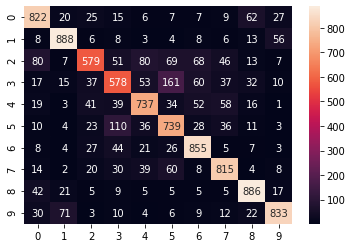

--------------------------------------------------------------------




In [ ]:
# Validating our model
model1 = SimpleCNN()
model1.load_state_dict(torch.load('simplecnn.pth'), strict=False)
model1.eval()
to_device(model1, device)
test(testloader, model1.cpu(), 'test')
classwise_test(testloader, model1.cpu())

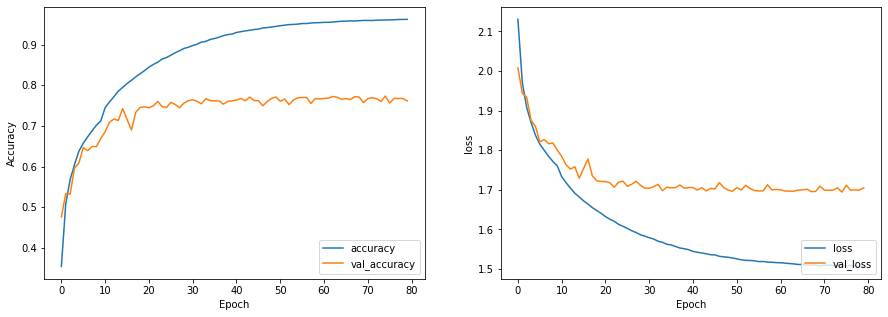

In [ ]:
plot_train_graphs(history1)

In [ ]:
# print model Summary
# simple cnn with cbam with channel and spatial attn in series
model2 = SimpleCNN('CBAM')
to_device(model2, device)
summary(model2, (3,32,32))

Model Complete
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Linear-2                    [-1, 2]              66
              ReLU-3                    [-1, 2]               0
            Linear-4                   [-1, 32]              96
            Linear-5                    [-1, 2]              66
              ReLU-6                    [-1, 2]               0
            Linear-7                   [-1, 32]              96
  ChannelAttention-8           [-1, 32, 32, 32]               0
            Conv2d-9            [-1, 1, 32, 32]              99
      BatchNorm2d-10            [-1, 1, 32, 32]               2
             ReLU-11            [-1, 1, 32, 32]               0
 SpatialAttention-12           [-1, 32, 32, 32]               0
             CBAM-13           [-1, 32, 32, 32]               0
      BatchNorm2d-14    

In [ ]:
# train model
f = open("simplecbam.txt", "w")
num_epochs = 80
history2 = fit(num_epochs, model2, train_loader, test_loader, f=f, model_path='simplecbam.pth')
f.close()


Epoch [0], train_loss: 2.1311, train_acc: 0.3466, val_loss: 2.0218, val_acc: 0.4533
model saved



Epoch [1], train_loss: 1.9779, train_acc: 0.4974, val_loss: 1.9376, val_acc: 0.5367
model saved



Epoch [2], train_loss: 1.9068, train_acc: 0.5695, val_loss: 1.8866, val_acc: 0.5905
model saved



Epoch [3], train_loss: 1.8613, train_acc: 0.6121, val_loss: 1.8572, val_acc: 0.6147
model saved



Epoch [4], train_loss: 1.8302, train_acc: 0.6417, val_loss: 1.8215, val_acc: 0.6501
model saved



Epoch [5], train_loss: 1.8092, train_acc: 0.6620, val_loss: 1.8280, val_acc: 0.6408



Epoch [6], train_loss: 1.7909, train_acc: 0.6807, val_loss: 1.8085, val_acc: 0.6586
model saved



Epoch [7], train_loss: 1.7755, train_acc: 0.6940, val_loss: 1.7942, val_acc: 0.6710
model saved



Epoch [8], train_loss: 1.7504, train_acc: 0.7237, val_loss: 1.7676, val_acc: 0.6997
model saved



Epoch [9], train_loss: 1.7273, train_acc: 0.7461, val_loss: 1.7670, val_acc: 0.6999
model saved



Epoch [10], train_loss: 1.7108, train_acc: 0.7633, val_loss: 1.7845, val_acc: 0.6814



Epoch [11], train_loss: 1.6967, train_acc: 0.7757, val_loss: 1.7493, val_acc: 0.7189
model saved



Epoch [12], train_loss: 1.6835, train_acc: 0.7903, val_loss: 1.7374, val_acc: 0.7291
model saved



Epoch [13], train_loss: 1.6730, train_acc: 0.7993, val_loss: 1.7424, val_acc: 0.7233



Epoch [14], train_loss: 1.6620, train_acc: 0.8111, val_loss: 1.7324, val_acc: 0.7324
model saved



Epoch [15], train_loss: 1.6535, train_acc: 0.8194, val_loss: 1.7226, val_acc: 0.7410
model saved



Epoch [16], train_loss: 1.6443, train_acc: 0.8280, val_loss: 1.7222, val_acc: 0.7430
model saved



Epoch [17], train_loss: 1.6365, train_acc: 0.8362, val_loss: 1.7408, val_acc: 0.7244



Epoch [18], train_loss: 1.6287, train_acc: 0.8434, val_loss: 1.7155, val_acc: 0.7488
model saved



Epoch [19], train_loss: 1.6225, train_acc: 0.8500, val_loss: 1.7181, val_acc: 0.7482



Epoch [20], train_loss: 1.6151, train_acc: 0.8575, val_loss: 1.7218, val_acc: 0.7425



Epoch [21], train_loss: 1.6101, train_acc: 0.8622, val_loss: 1.7211, val_acc: 0.7418



Epoch [22], train_loss: 1.6029, train_acc: 0.8693, val_loss: 1.7215, val_acc: 0.7426



Epoch [23], train_loss: 1.5998, train_acc: 0.8719, val_loss: 1.7132, val_acc: 0.7505
model saved



Epoch [24], train_loss: 1.5931, train_acc: 0.8795, val_loss: 1.7050, val_acc: 0.7597
model saved



Epoch [25], train_loss: 1.5890, train_acc: 0.8837, val_loss: 1.7157, val_acc: 0.7479



Epoch [26], train_loss: 1.5842, train_acc: 0.8878, val_loss: 1.7155, val_acc: 0.7485



Epoch [27], train_loss: 1.5793, train_acc: 0.8922, val_loss: 1.7161, val_acc: 0.7478



Epoch [28], train_loss: 1.5742, train_acc: 0.8977, val_loss: 1.7042, val_acc: 0.7606
model saved



Epoch [29], train_loss: 1.5706, train_acc: 0.9012, val_loss: 1.7100, val_acc: 0.7545



Epoch [30], train_loss: 1.5659, train_acc: 0.9064, val_loss: 1.7112, val_acc: 0.7544



Epoch [31], train_loss: 1.5636, train_acc: 0.9087, val_loss: 1.7066, val_acc: 0.7568



Epoch [32], train_loss: 1.5607, train_acc: 0.9106, val_loss: 1.7077, val_acc: 0.7576



Epoch [33], train_loss: 1.5569, train_acc: 0.9136, val_loss: 1.7247, val_acc: 0.7375



Epoch [34], train_loss: 1.5546, train_acc: 0.9167, val_loss: 1.7023, val_acc: 0.7624
model saved



Epoch [35], train_loss: 1.5519, train_acc: 0.9191, val_loss: 1.7146, val_acc: 0.7486



Epoch [36], train_loss: 1.5486, train_acc: 0.9214, val_loss: 1.7102, val_acc: 0.7527



Epoch [37], train_loss: 1.5469, train_acc: 0.9240, val_loss: 1.7006, val_acc: 0.7616



Epoch [38], train_loss: 1.5448, train_acc: 0.9259, val_loss: 1.7222, val_acc: 0.7381



Epoch [39], train_loss: 1.5416, train_acc: 0.9288, val_loss: 1.7030, val_acc: 0.7592



Epoch [40], train_loss: 1.5405, train_acc: 0.9302, val_loss: 1.7264, val_acc: 0.7370



Epoch [41], train_loss: 1.5396, train_acc: 0.9310, val_loss: 1.7190, val_acc: 0.7435



Epoch [42], train_loss: 1.5372, train_acc: 0.9328, val_loss: 1.7035, val_acc: 0.7614



Epoch [43], train_loss: 1.5358, train_acc: 0.9348, val_loss: 1.7059, val_acc: 0.7578



Epoch [44], train_loss: 1.5344, train_acc: 0.9353, val_loss: 1.7033, val_acc: 0.7583



Epoch [45], train_loss: 1.5311, train_acc: 0.9382, val_loss: 1.7057, val_acc: 0.7592



Epoch [46], train_loss: 1.5306, train_acc: 0.9394, val_loss: 1.7021, val_acc: 0.7605



Epoch [47], train_loss: 1.5288, train_acc: 0.9407, val_loss: 1.7016, val_acc: 0.7617



Epoch [48], train_loss: 1.5276, train_acc: 0.9416, val_loss: 1.7034, val_acc: 0.7590



Epoch [49], train_loss: 1.5261, train_acc: 0.9430, val_loss: 1.7111, val_acc: 0.7529



Epoch [50], train_loss: 1.5266, train_acc: 0.9430, val_loss: 1.7045, val_acc: 0.7599



Epoch [51], train_loss: 1.5253, train_acc: 0.9443, val_loss: 1.7050, val_acc: 0.7577



Epoch [52], train_loss: 1.5237, train_acc: 0.9456, val_loss: 1.7024, val_acc: 0.7594



Epoch [53], train_loss: 1.5213, train_acc: 0.9479, val_loss: 1.7142, val_acc: 0.7482



Epoch [54], train_loss: 1.5219, train_acc: 0.9474, val_loss: 1.7051, val_acc: 0.7580



Epoch [55], train_loss: 1.5211, train_acc: 0.9479, val_loss: 1.7092, val_acc: 0.7538



Epoch [56], train_loss: 1.5204, train_acc: 0.9487, val_loss: 1.7162, val_acc: 0.7468



Epoch [57], train_loss: 1.5188, train_acc: 0.9501, val_loss: 1.7064, val_acc: 0.7582



Epoch [58], train_loss: 1.5180, train_acc: 0.9506, val_loss: 1.7062, val_acc: 0.7570



Epoch [59], train_loss: 1.5177, train_acc: 0.9511, val_loss: 1.7103, val_acc: 0.7536



Epoch [60], train_loss: 1.5159, train_acc: 0.9524, val_loss: 1.7047, val_acc: 0.7594



Epoch [61], train_loss: 1.5169, train_acc: 0.9514, val_loss: 1.7214, val_acc: 0.7386



Epoch [62], train_loss: 1.5168, train_acc: 0.9521, val_loss: 1.7114, val_acc: 0.7542



Epoch [63], train_loss: 1.5144, train_acc: 0.9540, val_loss: 1.7023, val_acc: 0.7616



Epoch [64], train_loss: 1.5139, train_acc: 0.9545, val_loss: 1.7111, val_acc: 0.7519



Epoch [65], train_loss: 1.5136, train_acc: 0.9550, val_loss: 1.7062, val_acc: 0.7572



Epoch [66], train_loss: 1.5133, train_acc: 0.9556, val_loss: 1.7066, val_acc: 0.7559



Epoch [67], train_loss: 1.5136, train_acc: 0.9548, val_loss: 1.7047, val_acc: 0.7591



Epoch [68], train_loss: 1.5130, train_acc: 0.9556, val_loss: 1.7057, val_acc: 0.7569



Epoch [69], train_loss: 1.5121, train_acc: 0.9564, val_loss: 1.7094, val_acc: 0.7548



Epoch [70], train_loss: 1.5111, train_acc: 0.9573, val_loss: 1.7050, val_acc: 0.7596



Epoch [71], train_loss: 1.5104, train_acc: 0.9579, val_loss: 1.7014, val_acc: 0.7634
model saved



Epoch [72], train_loss: 1.5102, train_acc: 0.9581, val_loss: 1.7127, val_acc: 0.7508



Epoch [73], train_loss: 1.5098, train_acc: 0.9578, val_loss: 1.7075, val_acc: 0.7568



Epoch [74], train_loss: 1.5081, train_acc: 0.9596, val_loss: 1.7036, val_acc: 0.7581



Epoch [75], train_loss: 1.5077, train_acc: 0.9601, val_loss: 1.7057, val_acc: 0.7552



Epoch [76], train_loss: 1.5085, train_acc: 0.9592, val_loss: 1.7010, val_acc: 0.7621



Epoch [77], train_loss: 1.5081, train_acc: 0.9598, val_loss: 1.7076, val_acc: 0.7565



Epoch [78], train_loss: 1.5079, train_acc: 0.9603, val_loss: 1.7079, val_acc: 0.7580



Epoch [79], train_loss: 1.5083, train_acc: 0.9602, val_loss: 1.7138, val_acc: 0.7501


Model Complete




Accuracy of the network on the test images: 76.320000 %






class-wise accuracy


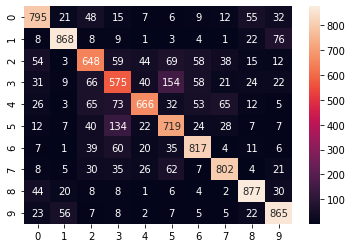

--------------------------------------------------------------------




In [ ]:
# Validating our model
model2 = SimpleCNN('CBAM')
model2.load_state_dict(torch.load('simplecbam.pth'), strict=False)
model2.eval()
to_device(model2, device)
test(testloader, model2.cpu(), 'test')
classwise_test(testloader, model2.cpu())

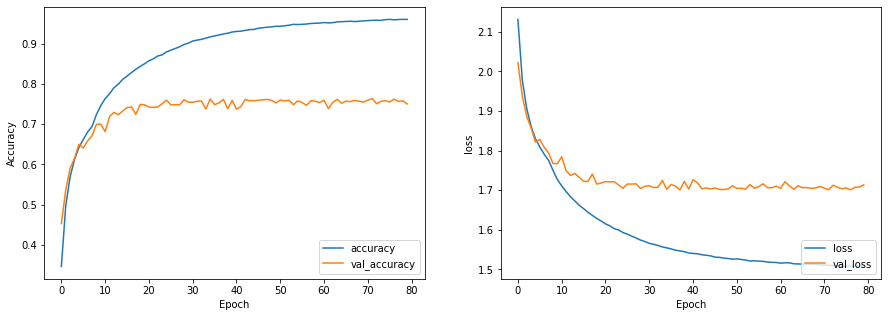

In [ ]:
plot_train_graphs(history2)

In [ ]:
# simple cnn with cbam with only channel attn
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio, pool_types):
        super(ChannelAttention, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels//reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels//reduction_ratio, in_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None 
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool.view(avg_pool.size(0), -1))
            elif pool_type=='max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool.view(max_pool.size(0), -1))

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        channel_att = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)

        return x * channel_att


class SpatialAttention(nn.Module):
    def __init__(self, k_size):
        super(SpatialAttention, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=k_size, padding=(k_size - 1)//2),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
    
    def forward(self, x):
        conv_concat = torch.cat((x.max(1)[0].unsqueeze(1), x.mean(1).unsqueeze(1)), dim=1)
        spatial_att_raw = self.conv_block(conv_concat)
        spatial_att = torch.sigmoid(spatial_att_raw).expand_as(x)
        return x * spatial_att


class CBAM(nn.Module):
    def __init__(self, in_channels, pool_types=['avg',"max"], k_size=7, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.CA = ChannelAttention(in_channels, reduction_ratio, pool_types)
        self.SA = SpatialAttention(k_size)
        
    def forward(self, x):
        channel_att = self.CA(x)
        #spatial_att = self.SA(channel_att)

        return channel_att

class SimpleCNN(ImageClassificationBase):
    def __init__(self, attention=None):
        super(SimpleCNN, self).__init__()
        # attention method
        self.attention = attention 
        # nb_channel and FCN size
        in_channels = 3
        fcn_size = 128*4*4
        
        self.feature_maps = OrderedDict()
        self.pool_locs = OrderedDict()

        self.features = nn.Sequential(
            # layer1
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),

            # layer2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),
 
            # layer3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=fcn_size, out_features=1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
            nn.Softmax(dim=1)
        )

        # Attention Modules
        if attention=='CBAM':
            ch_lst = [32,64,128]
            for i in range(3):
                self.__setattr__('cbam%d' % i, CBAM(ch_lst[i]))

        print('Model Complete')

    
    def forward(self, x):
        nb_layer = 0
        for _, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, _ = layer(x)
            elif isinstance(layer, nn.BatchNorm2d) and (self.attention=='CBAM'): # CBAM
                x = self.__getattr__('cbam%d' % nb_layer)(x)
                x = layer(x)
                nb_layer += 1
            else:
                x = layer(x)

        x = x.view(x.size(0), -1)
        output = self.classifier(x)

        return output

Model Complete
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Linear-2                    [-1, 2]              66
              ReLU-3                    [-1, 2]               0
            Linear-4                   [-1, 32]              96
            Linear-5                    [-1, 2]              66
              ReLU-6                    [-1, 2]               0
            Linear-7                   [-1, 32]              96
  ChannelAttention-8           [-1, 32, 32, 32]               0
              CBAM-9           [-1, 32, 32, 32]               0
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
        MaxPool2d-12  [[-1, 32, 16, 16], [-1, 32, 16, 16]]               0
           Conv2d-13           [-1, 64, 16, 16]          18,496
           Li


Epoch [0], train_loss: 2.1379, train_acc: 0.3395, val_loss: 2.0431, val_acc: 0.4328
model saved



Epoch [1], train_loss: 2.0059, train_acc: 0.4684, val_loss: 1.9731, val_acc: 0.4978
model saved



Epoch [2], train_loss: 1.9562, train_acc: 0.5139, val_loss: 1.9665, val_acc: 0.4993
model saved



Epoch [3], train_loss: 1.9220, train_acc: 0.5494, val_loss: 1.9450, val_acc: 0.5236
model saved



Epoch [4], train_loss: 1.8645, train_acc: 0.6138, val_loss: 1.8923, val_acc: 0.5750
model saved



Epoch [5], train_loss: 1.8080, train_acc: 0.6685, val_loss: 1.8194, val_acc: 0.6546
model saved



Epoch [6], train_loss: 1.7797, train_acc: 0.6950, val_loss: 1.8156, val_acc: 0.6523



Epoch [7], train_loss: 1.7563, train_acc: 0.7185, val_loss: 1.7849, val_acc: 0.6857
model saved



Epoch [8], train_loss: 1.7361, train_acc: 0.7371, val_loss: 1.7762, val_acc: 0.6912
model saved



Epoch [9], train_loss: 1.7232, train_acc: 0.7509, val_loss: 1.7757, val_acc: 0.6924
model saved



Epoch [10], train_loss: 1.7084, train_acc: 0.7652, val_loss: 1.7552, val_acc: 0.7100
model saved



Epoch [11], train_loss: 1.6968, train_acc: 0.7779, val_loss: 1.7382, val_acc: 0.7313
model saved



Epoch [12], train_loss: 1.6847, train_acc: 0.7888, val_loss: 1.7575, val_acc: 0.7088



Epoch [13], train_loss: 1.6761, train_acc: 0.7965, val_loss: 1.7381, val_acc: 0.7293



Epoch [14], train_loss: 1.6649, train_acc: 0.8084, val_loss: 1.7375, val_acc: 0.7286



Epoch [15], train_loss: 1.6588, train_acc: 0.8144, val_loss: 1.7450, val_acc: 0.7178



Epoch [16], train_loss: 1.6482, train_acc: 0.8242, val_loss: 1.7250, val_acc: 0.7447
model saved



Epoch [17], train_loss: 1.6416, train_acc: 0.8314, val_loss: 1.7201, val_acc: 0.7469
model saved



Epoch [18], train_loss: 1.6335, train_acc: 0.8392, val_loss: 1.7223, val_acc: 0.7416



Epoch [19], train_loss: 1.6281, train_acc: 0.8446, val_loss: 1.7431, val_acc: 0.7180



Epoch [20], train_loss: 1.6212, train_acc: 0.8515, val_loss: 1.7406, val_acc: 0.7249



Epoch [21], train_loss: 1.6154, train_acc: 0.8575, val_loss: 1.7273, val_acc: 0.7375



Epoch [22], train_loss: 1.6099, train_acc: 0.8625, val_loss: 1.7229, val_acc: 0.7404



Epoch [23], train_loss: 1.6025, train_acc: 0.8705, val_loss: 1.7135, val_acc: 0.7528
model saved



Epoch [24], train_loss: 1.5979, train_acc: 0.8740, val_loss: 1.7243, val_acc: 0.7403



Epoch [25], train_loss: 1.5939, train_acc: 0.8774, val_loss: 1.7145, val_acc: 0.7491



Epoch [26], train_loss: 1.5873, train_acc: 0.8852, val_loss: 1.7235, val_acc: 0.7401



Epoch [27], train_loss: 1.5835, train_acc: 0.8896, val_loss: 1.7394, val_acc: 0.7251



Epoch [28], train_loss: 1.5795, train_acc: 0.8928, val_loss: 1.7076, val_acc: 0.7569
model saved



Epoch [29], train_loss: 1.5771, train_acc: 0.8946, val_loss: 1.7183, val_acc: 0.7460



Epoch [30], train_loss: 1.5714, train_acc: 0.9004, val_loss: 1.7164, val_acc: 0.7484



Epoch [31], train_loss: 1.5686, train_acc: 0.9036, val_loss: 1.7126, val_acc: 0.7521



Epoch [32], train_loss: 1.5642, train_acc: 0.9078, val_loss: 1.7215, val_acc: 0.7400



Epoch [33], train_loss: 1.5620, train_acc: 0.9090, val_loss: 1.7010, val_acc: 0.7620
model saved



Epoch [34], train_loss: 1.5599, train_acc: 0.9116, val_loss: 1.7151, val_acc: 0.7488



Epoch [35], train_loss: 1.5561, train_acc: 0.9151, val_loss: 1.7162, val_acc: 0.7482



Epoch [36], train_loss: 1.5535, train_acc: 0.9177, val_loss: 1.7109, val_acc: 0.7529



Epoch [37], train_loss: 1.5498, train_acc: 0.9208, val_loss: 1.7130, val_acc: 0.7506



Epoch [38], train_loss: 1.5483, train_acc: 0.9216, val_loss: 1.7144, val_acc: 0.7501



Epoch [39], train_loss: 1.5455, train_acc: 0.9250, val_loss: 1.6979, val_acc: 0.7666
model saved



Epoch [40], train_loss: 1.5450, train_acc: 0.9252, val_loss: 1.7034, val_acc: 0.7615



Epoch [41], train_loss: 1.5426, train_acc: 0.9279, val_loss: 1.7127, val_acc: 0.7525



Epoch [42], train_loss: 1.5408, train_acc: 0.9296, val_loss: 1.7119, val_acc: 0.7502



Epoch [43], train_loss: 1.5397, train_acc: 0.9307, val_loss: 1.7133, val_acc: 0.7510



Epoch [44], train_loss: 1.5358, train_acc: 0.9342, val_loss: 1.7037, val_acc: 0.7609



Epoch [45], train_loss: 1.5354, train_acc: 0.9343, val_loss: 1.7038, val_acc: 0.7589



Epoch [46], train_loss: 1.5331, train_acc: 0.9366, val_loss: 1.7145, val_acc: 0.7474



Epoch [47], train_loss: 1.5318, train_acc: 0.9380, val_loss: 1.7012, val_acc: 0.7604



Epoch [48], train_loss: 1.5302, train_acc: 0.9400, val_loss: 1.7033, val_acc: 0.7605



Epoch [49], train_loss: 1.5289, train_acc: 0.9414, val_loss: 1.7032, val_acc: 0.7604



Epoch [50], train_loss: 1.5286, train_acc: 0.9406, val_loss: 1.7042, val_acc: 0.7598



Epoch [51], train_loss: 1.5256, train_acc: 0.9438, val_loss: 1.7091, val_acc: 0.7523



Epoch [52], train_loss: 1.5251, train_acc: 0.9441, val_loss: 1.7024, val_acc: 0.7631



Epoch [53], train_loss: 1.5262, train_acc: 0.9433, val_loss: 1.7084, val_acc: 0.7553



Epoch [54], train_loss: 1.5244, train_acc: 0.9453, val_loss: 1.7122, val_acc: 0.7506



Epoch [55], train_loss: 1.5224, train_acc: 0.9473, val_loss: 1.6985, val_acc: 0.7652



Epoch [56], train_loss: 1.5218, train_acc: 0.9471, val_loss: 1.7058, val_acc: 0.7582



Epoch [57], train_loss: 1.5209, train_acc: 0.9482, val_loss: 1.7037, val_acc: 0.7622



Epoch [58], train_loss: 1.5200, train_acc: 0.9492, val_loss: 1.7030, val_acc: 0.7598



Epoch [59], train_loss: 1.5181, train_acc: 0.9511, val_loss: 1.7099, val_acc: 0.7516



Epoch [60], train_loss: 1.5183, train_acc: 0.9510, val_loss: 1.6985, val_acc: 0.7650



Epoch [61], train_loss: 1.5165, train_acc: 0.9523, val_loss: 1.7128, val_acc: 0.7511



Epoch [62], train_loss: 1.5164, train_acc: 0.9523, val_loss: 1.7104, val_acc: 0.7530



Epoch [63], train_loss: 1.5151, train_acc: 0.9536, val_loss: 1.7102, val_acc: 0.7533



Epoch [64], train_loss: 1.5153, train_acc: 0.9536, val_loss: 1.7066, val_acc: 0.7559



Epoch [65], train_loss: 1.5156, train_acc: 0.9533, val_loss: 1.7084, val_acc: 0.7540



Epoch [66], train_loss: 1.5150, train_acc: 0.9543, val_loss: 1.7048, val_acc: 0.7586



Epoch [67], train_loss: 1.5137, train_acc: 0.9547, val_loss: 1.7087, val_acc: 0.7553



Epoch [68], train_loss: 1.5124, train_acc: 0.9561, val_loss: 1.7063, val_acc: 0.7573



Epoch [69], train_loss: 1.5127, train_acc: 0.9561, val_loss: 1.7128, val_acc: 0.7502



Epoch [70], train_loss: 1.5136, train_acc: 0.9552, val_loss: 1.7076, val_acc: 0.7542



Epoch [71], train_loss: 1.5132, train_acc: 0.9558, val_loss: 1.7099, val_acc: 0.7545



Epoch [72], train_loss: 1.5111, train_acc: 0.9570, val_loss: 1.7002, val_acc: 0.7644



Epoch [73], train_loss: 1.5102, train_acc: 0.9578, val_loss: 1.7068, val_acc: 0.7577



Epoch [74], train_loss: 1.5101, train_acc: 0.9583, val_loss: 1.7067, val_acc: 0.7575



Epoch [75], train_loss: 1.5096, train_acc: 0.9586, val_loss: 1.7061, val_acc: 0.7592



Epoch [76], train_loss: 1.5084, train_acc: 0.9598, val_loss: 1.7076, val_acc: 0.7562



Epoch [77], train_loss: 1.5086, train_acc: 0.9597, val_loss: 1.7026, val_acc: 0.7599



Epoch [78], train_loss: 1.5088, train_acc: 0.9599, val_loss: 1.7237, val_acc: 0.7405



Epoch [79], train_loss: 1.5081, train_acc: 0.9603, val_loss: 1.7161, val_acc: 0.7461
Model Complete




Accuracy of the network on the test images: 76.650000 %






class-wise accuracy


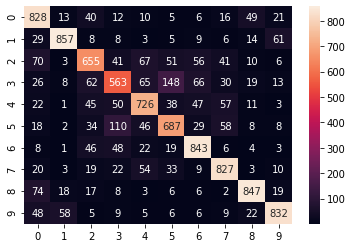

--------------------------------------------------------------------




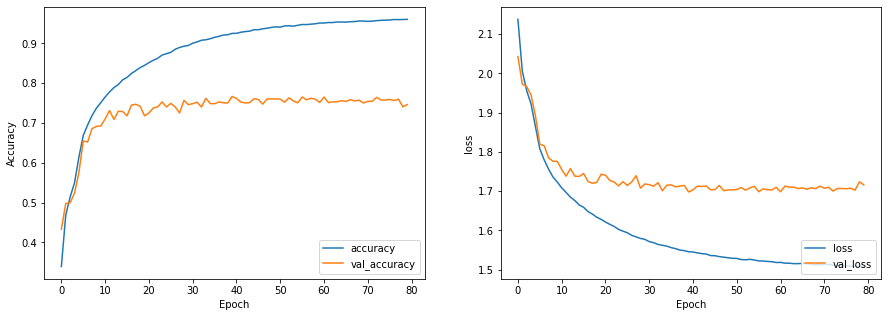

In [ ]:
# print model Summary
# simple cnn with cbam with only channel attn
model3 = SimpleCNN('CBAM')
to_device(model3, device)
summary(model3, (3,32,32))

# train model
f = open("simplecbamonlychannel.txt", "w")
num_epochs = 80
history3 = fit(num_epochs, model3, train_loader, test_loader, f=f, model_path='simplecbamonlychannel.pth')
f.close()

# Validating our model
model3 = SimpleCNN('CBAM')
model3.load_state_dict(torch.load('simplecbamonlychannel.pth'), strict=False)
model3.eval()
to_device(model3, device)
test(testloader, model3.cpu(), 'test')
classwise_test(testloader, model3.cpu())

plot_train_graphs(history3)

In [ ]:
# simple cnn with cbam with only spatial attn
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio, pool_types):
        super(ChannelAttention, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels//reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels//reduction_ratio, in_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None 
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool.view(avg_pool.size(0), -1))
            elif pool_type=='max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool.view(max_pool.size(0), -1))

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        channel_att = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)

        return x * channel_att


class SpatialAttention(nn.Module):
    def __init__(self, k_size):
        super(SpatialAttention, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=k_size, padding=(k_size - 1)//2),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
    
    def forward(self, x):
        conv_concat = torch.cat((x.max(1)[0].unsqueeze(1), x.mean(1).unsqueeze(1)), dim=1)
        spatial_att_raw = self.conv_block(conv_concat)
        spatial_att = torch.sigmoid(spatial_att_raw).expand_as(x)
        return x * spatial_att


class CBAM(nn.Module):
    def __init__(self, in_channels, pool_types=['avg',"max"], k_size=7, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.CA = ChannelAttention(in_channels, reduction_ratio, pool_types)
        self.SA = SpatialAttention(k_size)
        
    def forward(self, x):
        #channel_att = self.CA(x)
        spatial_att = self.SA(x)

        return spatial_att

class SimpleCNN(ImageClassificationBase):
    def __init__(self, attention=None):
        super(SimpleCNN, self).__init__()
        # attention method
        self.attention = attention 
        # nb_channel and FCN size
        in_channels = 3
        fcn_size = 128*4*4
        
        self.feature_maps = OrderedDict()
        self.pool_locs = OrderedDict()

        self.features = nn.Sequential(
            # layer1
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),

            # layer2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),
 
            # layer3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=fcn_size, out_features=1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
            nn.Softmax(dim=1)
        )

        # Attention Modules
        if attention=='CBAM':
            ch_lst = [32,64,128]
            for i in range(3):
                self.__setattr__('cbam%d' % i, CBAM(ch_lst[i]))

        print('Model Complete')

    
    def forward(self, x):
        nb_layer = 0
        for _, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, _ = layer(x)
            elif isinstance(layer, nn.BatchNorm2d) and (self.attention=='CBAM'): # CBAM
                x = self.__getattr__('cbam%d' % nb_layer)(x)
                x = layer(x)
                nb_layer += 1
            else:
                x = layer(x)

        x = x.view(x.size(0), -1)
        output = self.classifier(x)

        return output

Model Complete
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2            [-1, 1, 32, 32]              99
       BatchNorm2d-3            [-1, 1, 32, 32]               2
              ReLU-4            [-1, 1, 32, 32]               0
  SpatialAttention-5           [-1, 32, 32, 32]               0
              CBAM-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
         MaxPool2d-9  [[-1, 32, 16, 16], [-1, 32, 16, 16]]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
           Conv2d-11            [-1, 1, 16, 16]              99
      BatchNorm2d-12            [-1, 1, 16, 16]               2
             ReLU-13            [-1, 1, 16, 16]               0
 SpatialAtten


Epoch [0], train_loss: 2.1567, train_acc: 0.3150, val_loss: 2.0659, val_acc: 0.4144
model saved



Epoch [1], train_loss: 2.0117, train_acc: 0.4646, val_loss: 1.9557, val_acc: 0.5168
model saved



Epoch [2], train_loss: 1.9291, train_acc: 0.5457, val_loss: 1.9160, val_acc: 0.5530
model saved



Epoch [3], train_loss: 1.8868, train_acc: 0.5857, val_loss: 1.8908, val_acc: 0.5774
model saved



Epoch [4], train_loss: 1.8604, train_acc: 0.6110, val_loss: 1.8585, val_acc: 0.6109
model saved



Epoch [5], train_loss: 1.8356, train_acc: 0.6357, val_loss: 1.8348, val_acc: 0.6336
model saved



Epoch [6], train_loss: 1.8106, train_acc: 0.6632, val_loss: 1.8342, val_acc: 0.6367
model saved



Epoch [7], train_loss: 1.7901, train_acc: 0.6837, val_loss: 1.8312, val_acc: 0.6358



Epoch [8], train_loss: 1.7748, train_acc: 0.6969, val_loss: 1.8289, val_acc: 0.6359



Epoch [9], train_loss: 1.7595, train_acc: 0.7131, val_loss: 1.7957, val_acc: 0.6737
model saved



Epoch [10], train_loss: 1.7309, train_acc: 0.7459, val_loss: 1.7659, val_acc: 0.7026
model saved



Epoch [11], train_loss: 1.7121, train_acc: 0.7642, val_loss: 1.7541, val_acc: 0.7166
model saved



Epoch [12], train_loss: 1.6979, train_acc: 0.7777, val_loss: 1.7567, val_acc: 0.7120



Epoch [13], train_loss: 1.6868, train_acc: 0.7877, val_loss: 1.8144, val_acc: 0.6484



Epoch [14], train_loss: 1.6743, train_acc: 0.8012, val_loss: 1.7316, val_acc: 0.7375
model saved



Epoch [15], train_loss: 1.6658, train_acc: 0.8096, val_loss: 1.7243, val_acc: 0.7427
model saved



Epoch [16], train_loss: 1.6581, train_acc: 0.8173, val_loss: 1.7205, val_acc: 0.7485
model saved



Epoch [17], train_loss: 1.6474, train_acc: 0.8279, val_loss: 1.7325, val_acc: 0.7336



Epoch [18], train_loss: 1.6391, train_acc: 0.8372, val_loss: 1.7233, val_acc: 0.7427



Epoch [19], train_loss: 1.6327, train_acc: 0.8432, val_loss: 1.7122, val_acc: 0.7567
model saved



Epoch [20], train_loss: 1.6260, train_acc: 0.8496, val_loss: 1.7246, val_acc: 0.7411



Epoch [21], train_loss: 1.6192, train_acc: 0.8563, val_loss: 1.7116, val_acc: 0.7596
model saved



Epoch [22], train_loss: 1.6125, train_acc: 0.8628, val_loss: 1.7055, val_acc: 0.7626
model saved



Epoch [23], train_loss: 1.6065, train_acc: 0.8688, val_loss: 1.7108, val_acc: 0.7587



Epoch [24], train_loss: 1.6007, train_acc: 0.8755, val_loss: 1.7110, val_acc: 0.7553



Epoch [25], train_loss: 1.5947, train_acc: 0.8805, val_loss: 1.7071, val_acc: 0.7609



Epoch [26], train_loss: 1.5893, train_acc: 0.8859, val_loss: 1.7095, val_acc: 0.7561



Epoch [27], train_loss: 1.5851, train_acc: 0.8902, val_loss: 1.7012, val_acc: 0.7644
model saved



Epoch [28], train_loss: 1.5794, train_acc: 0.8957, val_loss: 1.7051, val_acc: 0.7600



Epoch [29], train_loss: 1.5749, train_acc: 0.9005, val_loss: 1.6970, val_acc: 0.7674
model saved



Epoch [30], train_loss: 1.5716, train_acc: 0.9035, val_loss: 1.6947, val_acc: 0.7719
model saved



Epoch [31], train_loss: 1.5662, train_acc: 0.9084, val_loss: 1.7045, val_acc: 0.7607



Epoch [32], train_loss: 1.5614, train_acc: 0.9133, val_loss: 1.7143, val_acc: 0.7494



Epoch [33], train_loss: 1.5588, train_acc: 0.9160, val_loss: 1.7010, val_acc: 0.7640



Epoch [34], train_loss: 1.5560, train_acc: 0.9184, val_loss: 1.7089, val_acc: 0.7595



Epoch [35], train_loss: 1.5541, train_acc: 0.9198, val_loss: 1.7051, val_acc: 0.7609



Epoch [36], train_loss: 1.5500, train_acc: 0.9235, val_loss: 1.7158, val_acc: 0.7499



Epoch [37], train_loss: 1.5478, train_acc: 0.9257, val_loss: 1.7014, val_acc: 0.7644



Epoch [38], train_loss: 1.5433, train_acc: 0.9304, val_loss: 1.6963, val_acc: 0.7697



Epoch [39], train_loss: 1.5417, train_acc: 0.9315, val_loss: 1.7147, val_acc: 0.7530



Epoch [40], train_loss: 1.5402, train_acc: 0.9328, val_loss: 1.6984, val_acc: 0.7670



Epoch [41], train_loss: 1.5372, train_acc: 0.9353, val_loss: 1.7009, val_acc: 0.7642



Epoch [42], train_loss: 1.5349, train_acc: 0.9378, val_loss: 1.6981, val_acc: 0.7671



Epoch [43], train_loss: 1.5327, train_acc: 0.9395, val_loss: 1.7122, val_acc: 0.7546



Epoch [44], train_loss: 1.5300, train_acc: 0.9417, val_loss: 1.7000, val_acc: 0.7657



Epoch [45], train_loss: 1.5296, train_acc: 0.9421, val_loss: 1.7022, val_acc: 0.7626



Epoch [46], train_loss: 1.5284, train_acc: 0.9431, val_loss: 1.6995, val_acc: 0.7655



Epoch [47], train_loss: 1.5267, train_acc: 0.9450, val_loss: 1.7094, val_acc: 0.7578



Epoch [48], train_loss: 1.5248, train_acc: 0.9467, val_loss: 1.6969, val_acc: 0.7679



Epoch [49], train_loss: 1.5233, train_acc: 0.9476, val_loss: 1.7010, val_acc: 0.7643



Epoch [50], train_loss: 1.5220, train_acc: 0.9482, val_loss: 1.6962, val_acc: 0.7695



Epoch [51], train_loss: 1.5204, train_acc: 0.9491, val_loss: 1.6996, val_acc: 0.7640



Epoch [52], train_loss: 1.5195, train_acc: 0.9505, val_loss: 1.7019, val_acc: 0.7632



Epoch [53], train_loss: 1.5188, train_acc: 0.9509, val_loss: 1.7003, val_acc: 0.7661



Epoch [54], train_loss: 1.5184, train_acc: 0.9518, val_loss: 1.6988, val_acc: 0.7663



Epoch [55], train_loss: 1.5171, train_acc: 0.9531, val_loss: 1.6935, val_acc: 0.7722
model saved



Epoch [56], train_loss: 1.5166, train_acc: 0.9532, val_loss: 1.7011, val_acc: 0.7656



Epoch [57], train_loss: 1.5150, train_acc: 0.9545, val_loss: 1.6984, val_acc: 0.7644



Epoch [58], train_loss: 1.5125, train_acc: 0.9561, val_loss: 1.6928, val_acc: 0.7737
model saved



Epoch [59], train_loss: 1.5116, train_acc: 0.9567, val_loss: 1.6987, val_acc: 0.7661



Epoch [60], train_loss: 1.5119, train_acc: 0.9571, val_loss: 1.7110, val_acc: 0.7527



Epoch [61], train_loss: 1.5121, train_acc: 0.9570, val_loss: 1.7077, val_acc: 0.7580



Epoch [62], train_loss: 1.5107, train_acc: 0.9578, val_loss: 1.6943, val_acc: 0.7716



Epoch [63], train_loss: 1.5101, train_acc: 0.9583, val_loss: 1.6988, val_acc: 0.7670



Epoch [64], train_loss: 1.5097, train_acc: 0.9588, val_loss: 1.6993, val_acc: 0.7660



Epoch [65], train_loss: 1.5088, train_acc: 0.9592, val_loss: 1.6985, val_acc: 0.7698



Epoch [66], train_loss: 1.5085, train_acc: 0.9597, val_loss: 1.6965, val_acc: 0.7692



Epoch [67], train_loss: 1.5076, train_acc: 0.9601, val_loss: 1.6937, val_acc: 0.7732



Epoch [68], train_loss: 1.5071, train_acc: 0.9607, val_loss: 1.7002, val_acc: 0.7649



Epoch [69], train_loss: 1.5070, train_acc: 0.9607, val_loss: 1.6948, val_acc: 0.7704



Epoch [70], train_loss: 1.5063, train_acc: 0.9615, val_loss: 1.6950, val_acc: 0.7712



Epoch [71], train_loss: 1.5054, train_acc: 0.9619, val_loss: 1.7003, val_acc: 0.7668



Epoch [72], train_loss: 1.5056, train_acc: 0.9619, val_loss: 1.6992, val_acc: 0.7657



Epoch [73], train_loss: 1.5043, train_acc: 0.9626, val_loss: 1.6932, val_acc: 0.7732



Epoch [74], train_loss: 1.5045, train_acc: 0.9626, val_loss: 1.6969, val_acc: 0.7703



Epoch [75], train_loss: 1.5044, train_acc: 0.9627, val_loss: 1.6981, val_acc: 0.7662



Epoch [76], train_loss: 1.5044, train_acc: 0.9629, val_loss: 1.6996, val_acc: 0.7687



Epoch [77], train_loss: 1.5043, train_acc: 0.9634, val_loss: 1.6986, val_acc: 0.7674



Epoch [78], train_loss: 1.5046, train_acc: 0.9631, val_loss: 1.6980, val_acc: 0.7685



Epoch [79], train_loss: 1.5045, train_acc: 0.9636, val_loss: 1.6979, val_acc: 0.7677
Model Complete




Accuracy of the network on the test images: 77.350000 %






class-wise accuracy


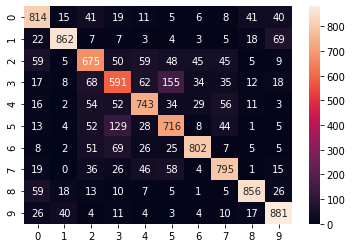

--------------------------------------------------------------------




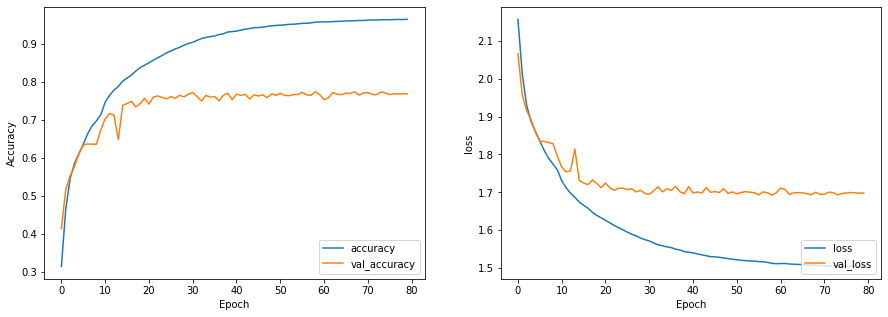

In [ ]:
# print model Summary
# simple cnn with cbam with only spatial attn
model4 = SimpleCNN('CBAM')
to_device(model4, device)
summary(model4, (3,32,32))

# train model
f = open("simplecbamonlyspatial.txt", "w")
num_epochs = 80
history4 = fit(num_epochs, model4, train_loader, test_loader, f=f, model_path='simplecbamonlyspatial.pth')
f.close()

# Validating our model
model4 = SimpleCNN('CBAM')
model4.load_state_dict(torch.load('simplecbamonlyspatial.pth'), strict=False)
model4.eval()
to_device(model4, device)
test(testloader, model4.cpu(), 'test')
classwise_test(testloader, model4.cpu())

plot_train_graphs(history4)

In [ ]:
# simple cnn with cbam with spatial and channel attn in parallel
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio, pool_types):
        super(ChannelAttention, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels//reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels//reduction_ratio, in_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None 
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool.view(avg_pool.size(0), -1))
            elif pool_type=='max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool.view(max_pool.size(0), -1))

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        channel_att = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)

        return x * channel_att


class SpatialAttention(nn.Module):
    def __init__(self, k_size):
        super(SpatialAttention, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=k_size, padding=(k_size - 1)//2),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
    
    def forward(self, x):
        conv_concat = torch.cat((x.max(1)[0].unsqueeze(1), x.mean(1).unsqueeze(1)), dim=1)
        spatial_att_raw = self.conv_block(conv_concat)
        spatial_att = torch.sigmoid(spatial_att_raw).expand_as(x)
        return x * spatial_att


class CBAM(nn.Module):
    def __init__(self, in_channels, pool_types=['avg',"max"], k_size=7, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.CA = ChannelAttention(in_channels, reduction_ratio, pool_types)
        self.SA = SpatialAttention(k_size)
        
    def forward(self, x):
        channel_att = self.CA(x)
        spatial_att = self.SA(x)

        return channel_att+spatial_att

class SimpleCNN(ImageClassificationBase):
    def __init__(self, attention=None):
        super(SimpleCNN, self).__init__()
        # attention method
        self.attention = attention 
        # nb_channel and FCN size
        in_channels = 3
        fcn_size = 128*4*4
        
        self.feature_maps = OrderedDict()
        self.pool_locs = OrderedDict()

        self.features = nn.Sequential(
            # layer1
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),

            # layer2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),
 
            # layer3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=fcn_size, out_features=1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
            nn.Softmax(dim=1)
        )

        # Attention Modules
        if attention=='CBAM':
            ch_lst = [32,64,128]
            for i in range(3):
                self.__setattr__('cbam%d' % i, CBAM(ch_lst[i]))

        print('Model Complete')

    
    def forward(self, x):
        nb_layer = 0
        for _, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, _ = layer(x)
            elif isinstance(layer, nn.BatchNorm2d) and (self.attention=='CBAM'): # CBAM
                x = self.__getattr__('cbam%d' % nb_layer)(x)
                x = layer(x)
                nb_layer += 1
            else:
                x = layer(x)

        x = x.view(x.size(0), -1)
        output = self.classifier(x)

        return output

Model Complete
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Linear-2                    [-1, 2]              66
              ReLU-3                    [-1, 2]               0
            Linear-4                   [-1, 32]              96
            Linear-5                    [-1, 2]              66
              ReLU-6                    [-1, 2]               0
            Linear-7                   [-1, 32]              96
  ChannelAttention-8           [-1, 32, 32, 32]               0
            Conv2d-9            [-1, 1, 32, 32]              99
      BatchNorm2d-10            [-1, 1, 32, 32]               2
             ReLU-11            [-1, 1, 32, 32]               0
 SpatialAttention-12           [-1, 32, 32, 32]               0
             CBAM-13           [-1, 32, 32, 32]               0
      BatchNorm2d-14    


Epoch [0], train_loss: 2.1362, train_acc: 0.3475, val_loss: 2.0216, val_acc: 0.4577
model saved



Epoch [1], train_loss: 1.9766, train_acc: 0.5015, val_loss: 1.9789, val_acc: 0.4964
model saved



Epoch [2], train_loss: 1.9112, train_acc: 0.5637, val_loss: 1.9127, val_acc: 0.5604
model saved



Epoch [3], train_loss: 1.8682, train_acc: 0.6059, val_loss: 1.8742, val_acc: 0.5971
model saved



Epoch [4], train_loss: 1.8359, train_acc: 0.6386, val_loss: 1.8325, val_acc: 0.6394
model saved



Epoch [5], train_loss: 1.8146, train_acc: 0.6574, val_loss: 1.8598, val_acc: 0.6040



Epoch [6], train_loss: 1.7966, train_acc: 0.6758, val_loss: 1.8257, val_acc: 0.6421
model saved



Epoch [7], train_loss: 1.7839, train_acc: 0.6881, val_loss: 1.8173, val_acc: 0.6523
model saved



Epoch [8], train_loss: 1.7711, train_acc: 0.7010, val_loss: 1.8168, val_acc: 0.6484



Epoch [9], train_loss: 1.7607, train_acc: 0.7110, val_loss: 1.7933, val_acc: 0.6734
model saved



Epoch [10], train_loss: 1.7514, train_acc: 0.7202, val_loss: 1.8039, val_acc: 0.6607



Epoch [11], train_loss: 1.7416, train_acc: 0.7303, val_loss: 1.8192, val_acc: 0.6445



Epoch [12], train_loss: 1.7327, train_acc: 0.7400, val_loss: 1.7894, val_acc: 0.6745
model saved



Epoch [13], train_loss: 1.7246, train_acc: 0.7465, val_loss: 1.7880, val_acc: 0.6794
model saved



Epoch [14], train_loss: 1.7174, train_acc: 0.7550, val_loss: 1.7775, val_acc: 0.6903
model saved



Epoch [15], train_loss: 1.7091, train_acc: 0.7636, val_loss: 1.7700, val_acc: 0.6969
model saved



Epoch [16], train_loss: 1.7037, train_acc: 0.7692, val_loss: 1.7748, val_acc: 0.6935



Epoch [17], train_loss: 1.6973, train_acc: 0.7761, val_loss: 1.7695, val_acc: 0.6968



Epoch [18], train_loss: 1.6918, train_acc: 0.7817, val_loss: 1.7926, val_acc: 0.6715



Epoch [19], train_loss: 1.6873, train_acc: 0.7853, val_loss: 1.7683, val_acc: 0.6976
model saved



Epoch [20], train_loss: 1.6801, train_acc: 0.7922, val_loss: 1.7677, val_acc: 0.6984
model saved



Epoch [21], train_loss: 1.6750, train_acc: 0.7977, val_loss: 1.7571, val_acc: 0.7102
model saved



Epoch [22], train_loss: 1.6705, train_acc: 0.8027, val_loss: 1.7546, val_acc: 0.7130
model saved



Epoch [23], train_loss: 1.6662, train_acc: 0.8063, val_loss: 1.7685, val_acc: 0.6972



Epoch [24], train_loss: 1.6529, train_acc: 0.8241, val_loss: 1.7499, val_acc: 0.7180
model saved



Epoch [25], train_loss: 1.6360, train_acc: 0.8415, val_loss: 1.7280, val_acc: 0.7408
model saved



Epoch [26], train_loss: 1.6259, train_acc: 0.8524, val_loss: 1.7327, val_acc: 0.7347



Epoch [27], train_loss: 1.6181, train_acc: 0.8596, val_loss: 1.7334, val_acc: 0.7327



Epoch [28], train_loss: 1.6107, train_acc: 0.8660, val_loss: 1.7196, val_acc: 0.7480
model saved



Epoch [29], train_loss: 1.6032, train_acc: 0.8750, val_loss: 1.7155, val_acc: 0.7519
model saved



Epoch [30], train_loss: 1.5960, train_acc: 0.8820, val_loss: 1.7201, val_acc: 0.7476



Epoch [31], train_loss: 1.5910, train_acc: 0.8852, val_loss: 1.7189, val_acc: 0.7463



Epoch [32], train_loss: 1.5859, train_acc: 0.8915, val_loss: 1.7193, val_acc: 0.7498



Epoch [33], train_loss: 1.5800, train_acc: 0.8975, val_loss: 1.7138, val_acc: 0.7553
model saved



Epoch [34], train_loss: 1.5745, train_acc: 0.9016, val_loss: 1.7204, val_acc: 0.7453



Epoch [35], train_loss: 1.5709, train_acc: 0.9058, val_loss: 1.7169, val_acc: 0.7506



Epoch [36], train_loss: 1.5656, train_acc: 0.9106, val_loss: 1.7107, val_acc: 0.7559
model saved



Epoch [37], train_loss: 1.5622, train_acc: 0.9144, val_loss: 1.7143, val_acc: 0.7538



Epoch [38], train_loss: 1.5593, train_acc: 0.9170, val_loss: 1.7078, val_acc: 0.7617
model saved



Epoch [39], train_loss: 1.5557, train_acc: 0.9201, val_loss: 1.7048, val_acc: 0.7613



Epoch [40], train_loss: 1.5525, train_acc: 0.9234, val_loss: 1.7154, val_acc: 0.7513



Epoch [41], train_loss: 1.5499, train_acc: 0.9247, val_loss: 1.7080, val_acc: 0.7587



Epoch [42], train_loss: 1.5468, train_acc: 0.9282, val_loss: 1.7156, val_acc: 0.7478



Epoch [43], train_loss: 1.5442, train_acc: 0.9308, val_loss: 1.7166, val_acc: 0.7472



Epoch [44], train_loss: 1.5413, train_acc: 0.9332, val_loss: 1.7101, val_acc: 0.7581



Epoch [45], train_loss: 1.5385, train_acc: 0.9359, val_loss: 1.7129, val_acc: 0.7551



Epoch [46], train_loss: 1.5364, train_acc: 0.9375, val_loss: 1.7072, val_acc: 0.7571



Epoch [47], train_loss: 1.5352, train_acc: 0.9381, val_loss: 1.7141, val_acc: 0.7510



Epoch [48], train_loss: 1.5325, train_acc: 0.9411, val_loss: 1.7080, val_acc: 0.7564



Epoch [49], train_loss: 1.5295, train_acc: 0.9435, val_loss: 1.7154, val_acc: 0.7480



Epoch [50], train_loss: 1.5294, train_acc: 0.9434, val_loss: 1.7154, val_acc: 0.7514



Epoch [51], train_loss: 1.5266, train_acc: 0.9456, val_loss: 1.7036, val_acc: 0.7627
model saved



Epoch [52], train_loss: 1.5258, train_acc: 0.9461, val_loss: 1.7140, val_acc: 0.7524



Epoch [53], train_loss: 1.5242, train_acc: 0.9477, val_loss: 1.7154, val_acc: 0.7497



Epoch [54], train_loss: 1.5230, train_acc: 0.9487, val_loss: 1.7035, val_acc: 0.7627



Epoch [55], train_loss: 1.5203, train_acc: 0.9509, val_loss: 1.7139, val_acc: 0.7515



Epoch [56], train_loss: 1.5199, train_acc: 0.9514, val_loss: 1.7136, val_acc: 0.7514



Epoch [57], train_loss: 1.5185, train_acc: 0.9523, val_loss: 1.7046, val_acc: 0.7616



Epoch [58], train_loss: 1.5174, train_acc: 0.9529, val_loss: 1.7032, val_acc: 0.7630
model saved



Epoch [59], train_loss: 1.5168, train_acc: 0.9535, val_loss: 1.7044, val_acc: 0.7612



Epoch [60], train_loss: 1.5157, train_acc: 0.9545, val_loss: 1.7069, val_acc: 0.7601



Epoch [61], train_loss: 1.5146, train_acc: 0.9557, val_loss: 1.7091, val_acc: 0.7589



Epoch [62], train_loss: 1.5136, train_acc: 0.9563, val_loss: 1.7015, val_acc: 0.7672
model saved



Epoch [63], train_loss: 1.5125, train_acc: 0.9570, val_loss: 1.7077, val_acc: 0.7595



Epoch [64], train_loss: 1.5122, train_acc: 0.9576, val_loss: 1.7024, val_acc: 0.7639



Epoch [65], train_loss: 1.5122, train_acc: 0.9574, val_loss: 1.7040, val_acc: 0.7611



Epoch [66], train_loss: 1.5108, train_acc: 0.9586, val_loss: 1.7060, val_acc: 0.7595



Epoch [67], train_loss: 1.5105, train_acc: 0.9585, val_loss: 1.7034, val_acc: 0.7589



Epoch [68], train_loss: 1.5104, train_acc: 0.9589, val_loss: 1.7079, val_acc: 0.7572



Epoch [69], train_loss: 1.5097, train_acc: 0.9592, val_loss: 1.7059, val_acc: 0.7604



Epoch [70], train_loss: 1.5087, train_acc: 0.9600, val_loss: 1.7093, val_acc: 0.7561



Epoch [71], train_loss: 1.5081, train_acc: 0.9603, val_loss: 1.7062, val_acc: 0.7565



Epoch [72], train_loss: 1.5070, train_acc: 0.9609, val_loss: 1.7146, val_acc: 0.7504



Epoch [73], train_loss: 1.5064, train_acc: 0.9611, val_loss: 1.7061, val_acc: 0.7588



Epoch [74], train_loss: 1.5068, train_acc: 0.9614, val_loss: 1.7093, val_acc: 0.7584



Epoch [75], train_loss: 1.5062, train_acc: 0.9617, val_loss: 1.7033, val_acc: 0.7625



Epoch [76], train_loss: 1.5064, train_acc: 0.9620, val_loss: 1.7074, val_acc: 0.7604



Epoch [77], train_loss: 1.5066, train_acc: 0.9619, val_loss: 1.7067, val_acc: 0.7586



Epoch [78], train_loss: 1.5053, train_acc: 0.9626, val_loss: 1.7087, val_acc: 0.7580



Epoch [79], train_loss: 1.5052, train_acc: 0.9628, val_loss: 1.7037, val_acc: 0.7648
Model Complete




Accuracy of the network on the test images: 66.340000 %






class-wise accuracy


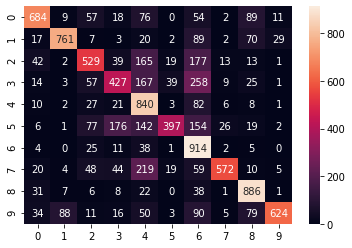

--------------------------------------------------------------------




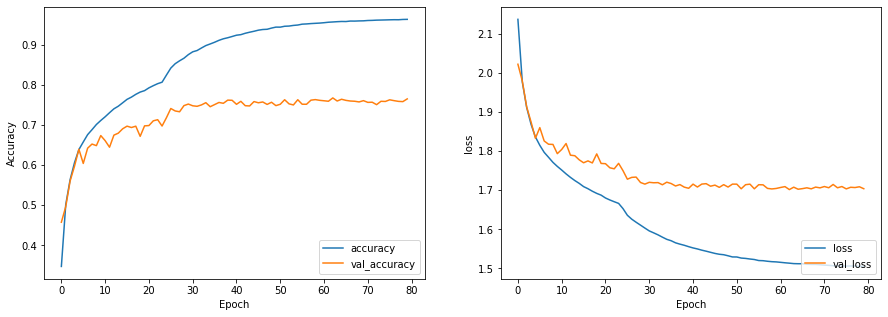

In [ ]:
# print model Summary
# simple cnn with cbam with spatial and channel attn in parallel
model5 = SimpleCNN('CBAM')
to_device(model5, device)
summary(model5, (3,32,32))

# train model
f = open("simplecbamparallel.txt", "w")
num_epochs = 80
history5 = fit(num_epochs, model5, train_loader, test_loader, f=f, model_path='simplecbamparallel.pth')
f.close()

# Validating our model
model5 = SimpleCNN()
model5.load_state_dict(torch.load('simplecbamparallel.pth'), strict=False)
model5.eval()
to_device(model5, device)
test(testloader, model5.cpu(), 'test')
classwise_test(testloader, model5.cpu())

plot_train_graphs(history5)